# Setup

In [28]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neurometry"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


# Imports

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import json

import default_config as config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import viz

import neurometry.datasets.utils as utils

# Get config for the run of interest

## Specify run ID

In [31]:
run_id = "9dba44c3"

## Load run config

In [32]:
CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    if run_id in config_file:
        print(config_file)
        run_id_config_file = config_file

with open(
    os.path.join(CONFIG_DIR, run_id_config_file),
) as f:
    config_dict = json.load(f)


# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)

Config in directory: /home/facosta/neurometry/neurometry/results/configs:
run_9dba44c3_s1_synthetic_noise_var_0.001_embedding_dim_3.json


# Get data & model

## Load data

In [33]:
dataset_torch, labels, train_loader, test_loader = utils.load(config)
dataset_torch = dataset_torch.to(config.device)
_, data_dim = dataset_torch.shape

Dataset shape: torch.Size([2000, 3]).


## Load model

In [34]:
trained_models_dir = os.path.join(os.getcwd() + "/results/trained_models")

model_path = os.path.join(trained_models_dir, f"{config.results_prefix}_model.pt")
model = torch.load(model_path)

## Get learned immersion $f$ and neural metric

In [35]:
import evaluate
from geomstats.geometry.pullback_metric import PullbackMetric

learned_immersion = evaluate.get_learned_immersion(model, config)

neural_metric = PullbackMetric(
    dim=1, embedding_dim=config.data_dim, immersion=learned_immersion
)

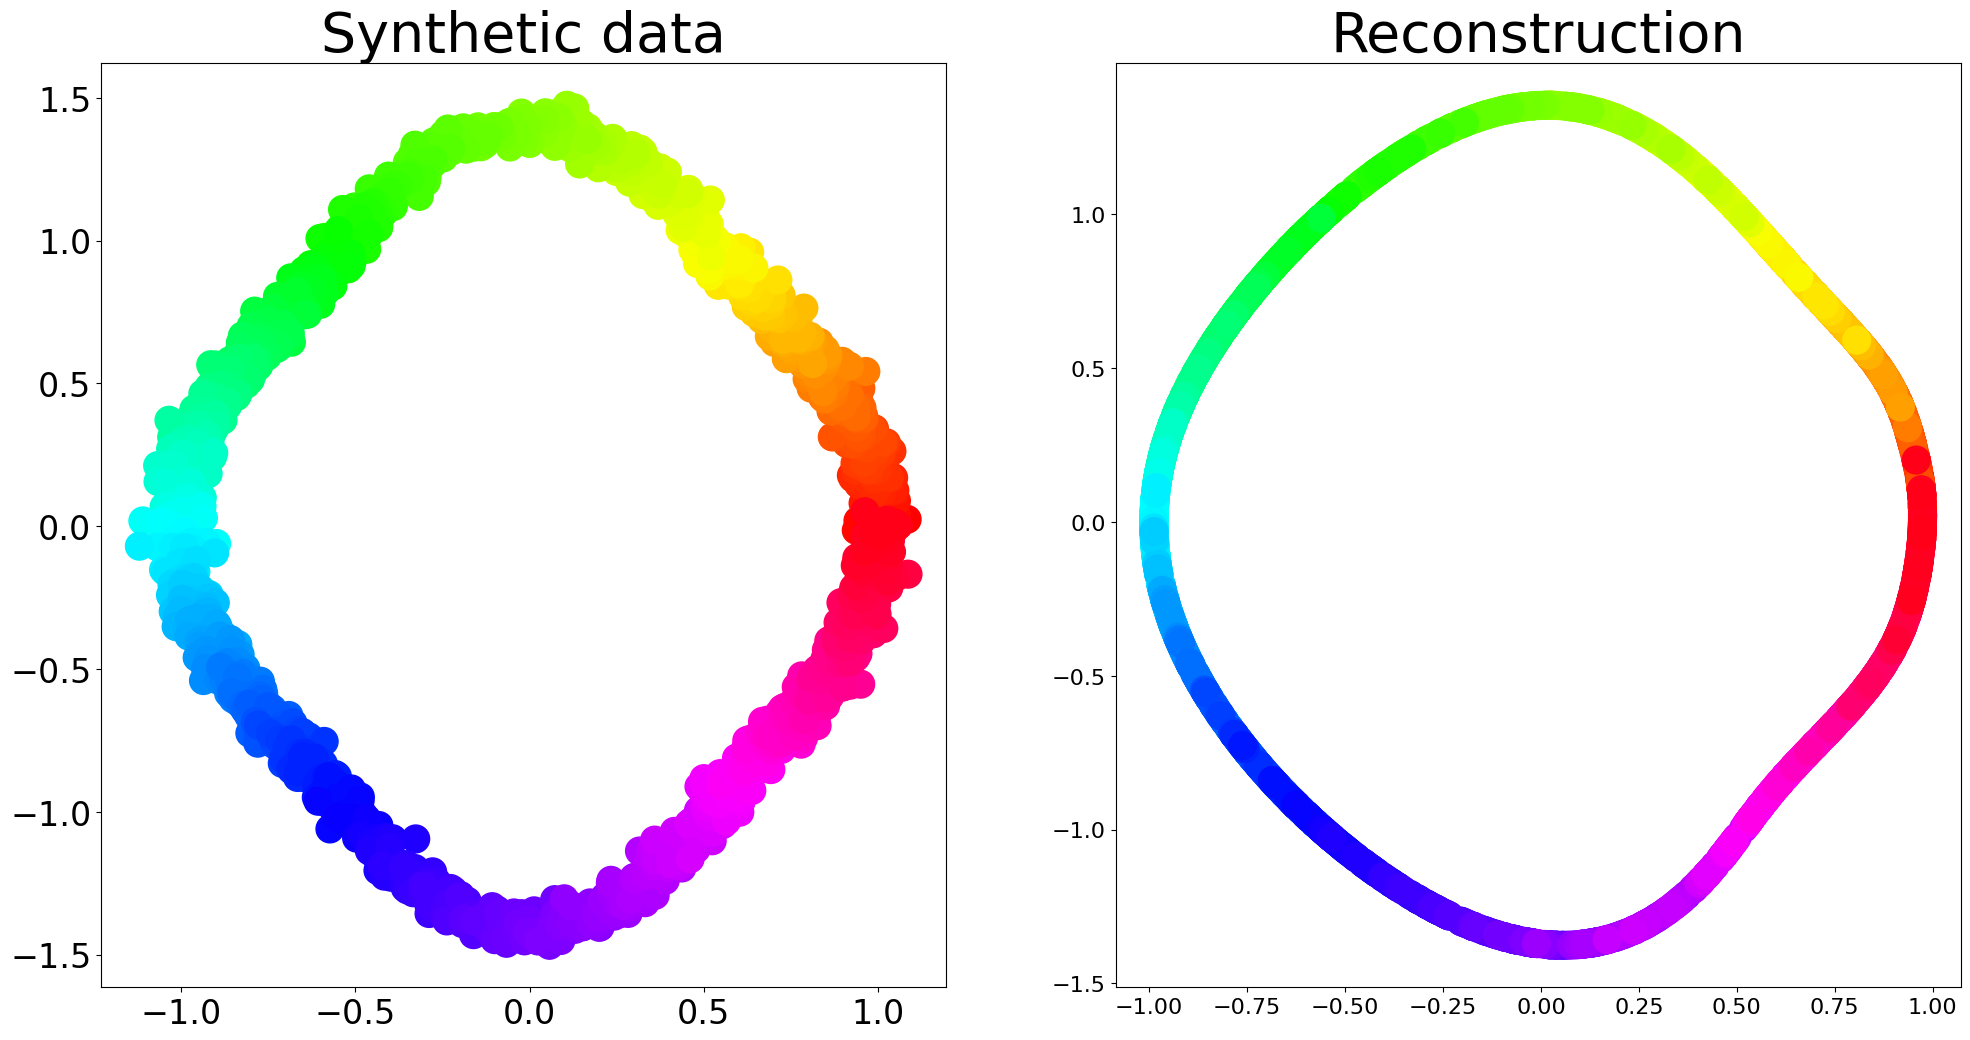

In [36]:
viz.plot_recon_per_positional_angle(model, dataset_torch, labels, config);

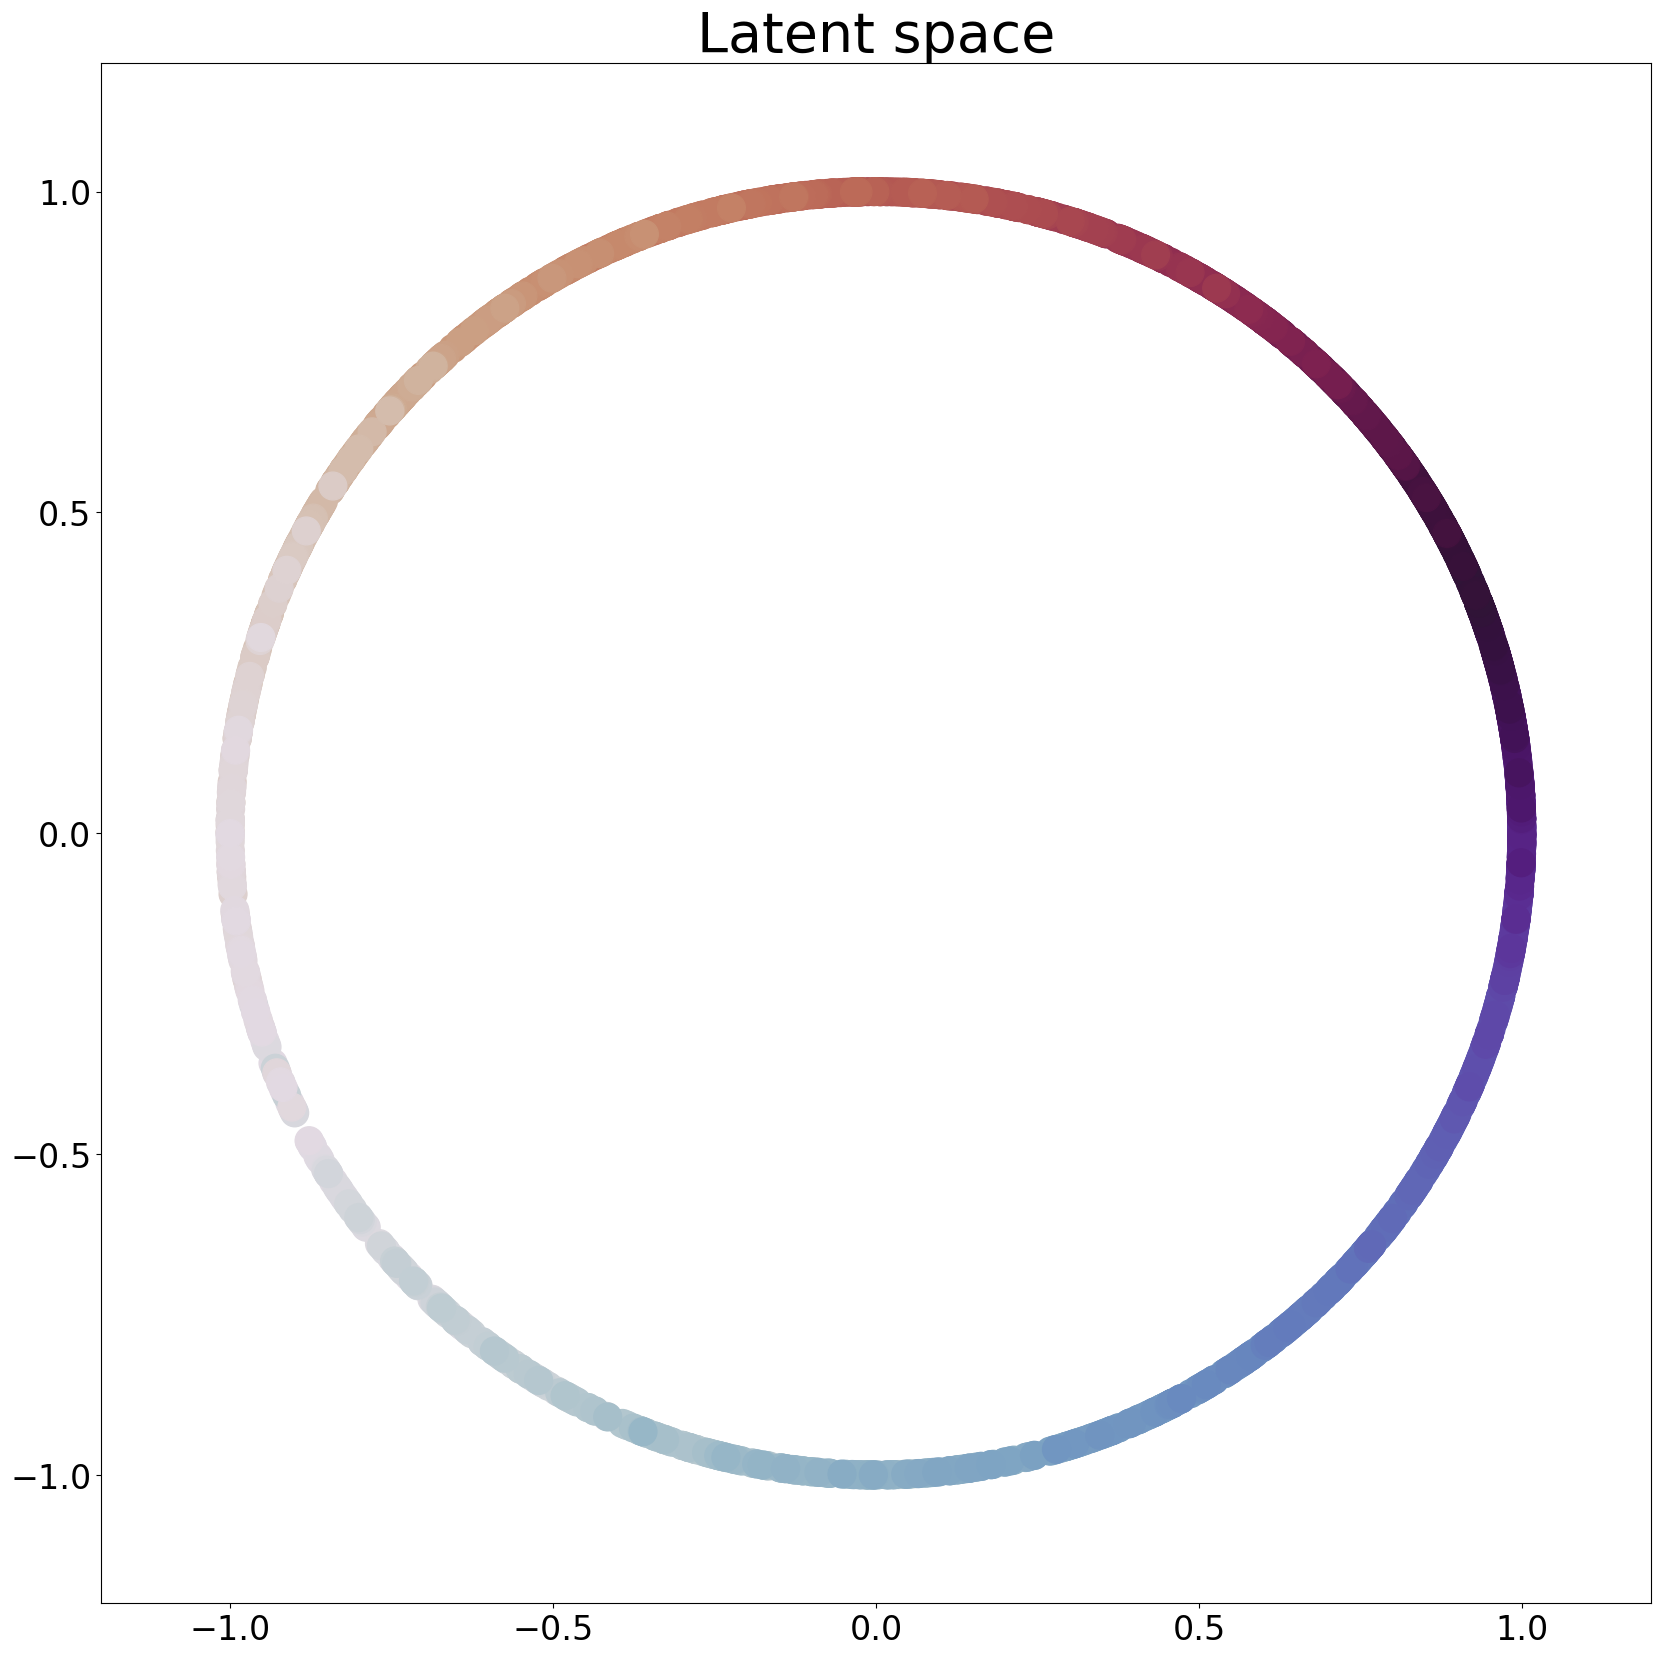

In [37]:
viz.plot_latent_space(model, dataset_torch, labels, config);

# Towards parameterization invariance

## Compute true curvature

In [38]:
true_immersion = evaluate.get_true_immersion(config)
(
    z_grid_true,
    geodesic_dist_true,
    curv_true,
    curv_norms_true,
) = evaluate.compute_curvature_true(config, 100)

Computation time: 1.159 seconds.


## Compute learned curvature

In [39]:
(
    z_grid_learned,
    geodesic_dists_learned,
    curv_learned,
    curv_norms_learned,
) = evaluate.compute_curvature_learned(
    model, config, embedding_dim=3, n_grid_points=100
)

Computation time: 6.319 seconds.


## Parallel computations of geodesic distances

In [40]:
import copy
import logging
import time

from joblib import Parallel, delayed

model.to("cuda:0")
# z_grid = torch.tensor(curv_norm_learned_profile["z_grid"].values)
z0 = torch.unsqueeze(z_grid_learned[0], dim=0)


# TODO (use logging to actually print and know which iterations we are on)
def _geodesic_dist(i_z, z, grid_interval):
    if i_z == 0:
        return (0, torch.tensor(0.0))
    # Parallelize on gpus: is that line really helping,
    # i.e. is the copy taking less time than the computation? if not, don't bother
    # also: does it change anything since neural metric has already been computed and uses the old version of model?
    copy.deepcopy(model).to(f"cuda:{i_z % 9}")
    z = torch.unsqueeze(z, dim=0)
    z_previous = torch.unsqueeze(z_grid_learned[i_z - grid_interval], dim=0)
    start = time.time()
    # Tricks to speed up this computation:
    # 1. Compute with less number of steps for the integration of the geodesic eqn
    # 2. Compute distance between neighboring z's
    dist = neural_metric.dist(z_previous, z, n_steps=10)
    duration = time.time() - start
    logging.info(f"Time (it: {i_z}): {duration:.3f}")
    return (i_z, dist)


# To try this code , use z_grid[:5] to run on smaller batch
# Currently, the z_grid is too big (~800) --> go to 100
# Note: each distance computation takes ~5s.
grid_interval = 1
res = Parallel(n_jobs=-1)(
    delayed(_geodesic_dist)(i_z, z, grid_interval)
    for i_z, z in enumerate(z_grid_learned)
    if i_z % grid_interval == 0
)

INFO: Using pytorch backend
INFO: Time (it: 32): 2.062
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Time (it: 9): 4.064
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Using pytorch backend
INFO: Time (it: 18): 4.346
INFO: Using pytorch backend
INFO: Time (it: 27): 2.8

In [41]:
geodesic_dists_learned = torch.zeros(len(res))
curv_series_learned = pd.Series(curv_norms_learned.numpy())
curv_norms_learned = torch.zeros(len(res))
for i_z, dist in res:
    geodesic_dists_learned[i_z] = dist
    curv_norms_learned[i_z] = curv_series_learned.values[i_z]

cumul_geodesic_dists_learned = torch.cumsum(geodesic_dists_learned, dim=0)

In [42]:
def remove_outliers(x1, x2, y):
    threshold = 10 * np.median(y)
    x1 = x1[y < threshold]
    x2 = x2[y < threshold]
    y = y[y < threshold]

    return x1, x2, y

In [43]:
if isinstance(curv_norms_learned, torch.Tensor):
    curv_norms_learned = curv_norms_learned.numpy()
if isinstance(curv_norms_true, torch.Tensor):
    curv_norms_true = curv_norms_true.numpy()
if isinstance(cumul_geodesic_dists_learned, torch.Tensor):
    cumul_geodesic_dists_learned = cumul_geodesic_dists_learned.numpy()

# Obtain true and learned "shape" of curvature profile

In [44]:
# z_grid_learned, cumul_geodesic_dists_learned, curv_norms_learned = remove_outliers(
#     z_grid_learned, cumul_geodesic_dists_learned, curv_norms_learned
# )

In [45]:
import scipy


# function to find best alignment
def get_cross_corr(signal1, signal2):
    s1 = np.squeeze(signal1)
    mean_s1 = np.mean(s1)
    s1 = s1 - mean_s1
    s2 = np.squeeze(signal2)
    mean_s2 = np.mean(s2)
    s2 = s2 - mean_s2
    correlation = np.correlate(s1, s2, mode="same")
    lags = scipy.signal.correlation_lags(s1.size, s2.size, mode="same")
    lag = lags[np.argmax(correlation)]
    s1 = np.roll(s1, -lag)
    s1 += mean_s1
    return s1, correlation

## Quotient out global scaling

In [46]:
scaling_factor = 2 * np.pi / np.max(cumul_geodesic_dists_learned)

rescaled_curv_norms_learned = curv_norms_learned * scaling_factor

rescaled_cumul_geodesic_dists_learned = cumul_geodesic_dists_learned * scaling_factor

## Quotient out global rotation

In [47]:
# ensures that the true profile and the learned profile are sampled at the same points
curv_norms_true_interp = np.interp(
    rescaled_cumul_geodesic_dists_learned, z_grid_true, curv_norms_true
)

# computes cross-correlation between true and learned curvature profiles, returns offset of best alignment
aligned_curv_norms_learned, correlation = get_cross_corr(
    rescaled_curv_norms_learned, curv_norms_true_interp
)

## Plot curvature shapes

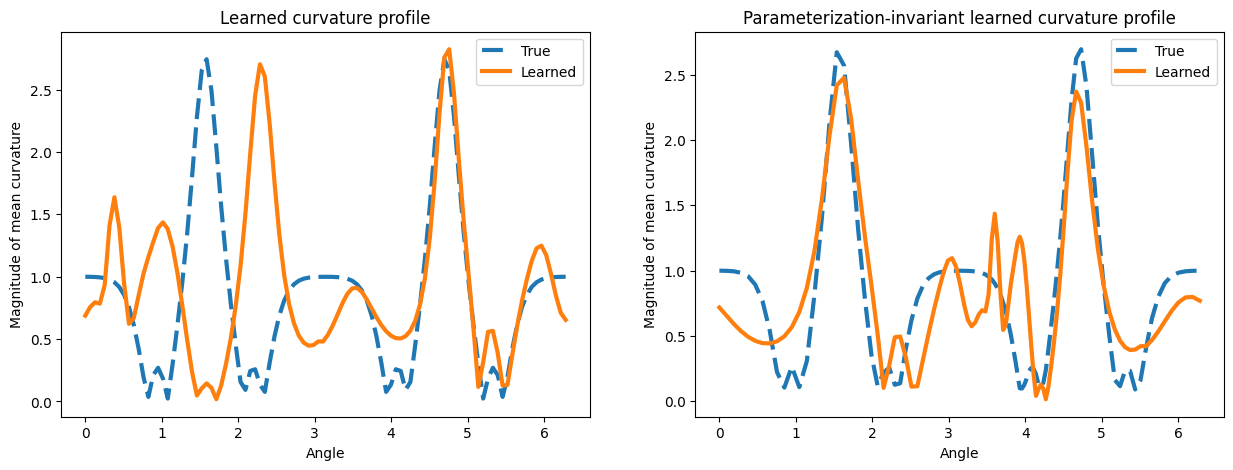

In [48]:
smoothing = False

fig = plt.figure(figsize=(15, 5))
ax_no_geodesic = fig.add_subplot(121)
curv_norms_learned, _ = get_cross_corr(curv_norms_learned, curv_norms_true)

ax_no_geodesic.plot(
    z_grid_true, curv_norms_true, label="True", dashes=[5, 2], linewidth=3
)
ax_no_geodesic.plot(z_grid_learned, curv_norms_learned, label="Learned", linewidth=3)
ax_no_geodesic.legend()
ax_no_geodesic.set_xlabel("Angle")
ax_no_geodesic.set_ylabel("Magnitude of mean curvature")
ax_no_geodesic.set_title("Learned curvature profile")


ax_geodesic = fig.add_subplot(122)

if smoothing:
    aligned_curv_norms_learned = scipy.signal.savgol_filter(
        aligned_curv_norms_learned, window_length=15, polyorder=7
    )

ax_geodesic.plot(
    rescaled_cumul_geodesic_dists_learned,
    curv_norms_true_interp,
    label="True",
    dashes=[5, 2],
    linewidth=3,
)
ax_geodesic.plot(
    rescaled_cumul_geodesic_dists_learned,
    aligned_curv_norms_learned,
    label="Learned",
    linewidth=3,
)
ax_geodesic.legend()
ax_geodesic.set_xlabel("Angle")
ax_geodesic.set_ylabel("Magnitude of mean curvature")
ax_geodesic.set_title("Parameterization-invariant learned curvature profile")

CURVATURE_SHAPES_DIR = os.path.join(os.getcwd(), "results", "curvature_shapes")

plt.savefig(
    os.path.join(CURVATURE_SHAPES_DIR, f"param_inv_s1_run_id_{run_id}_profile.png")
)
plt.savefig(
    os.path.join(CURVATURE_SHAPES_DIR, f"param_inv_s1_run_id_{run_id}_profile.svg")
)

## Plot curvature shapes, polar

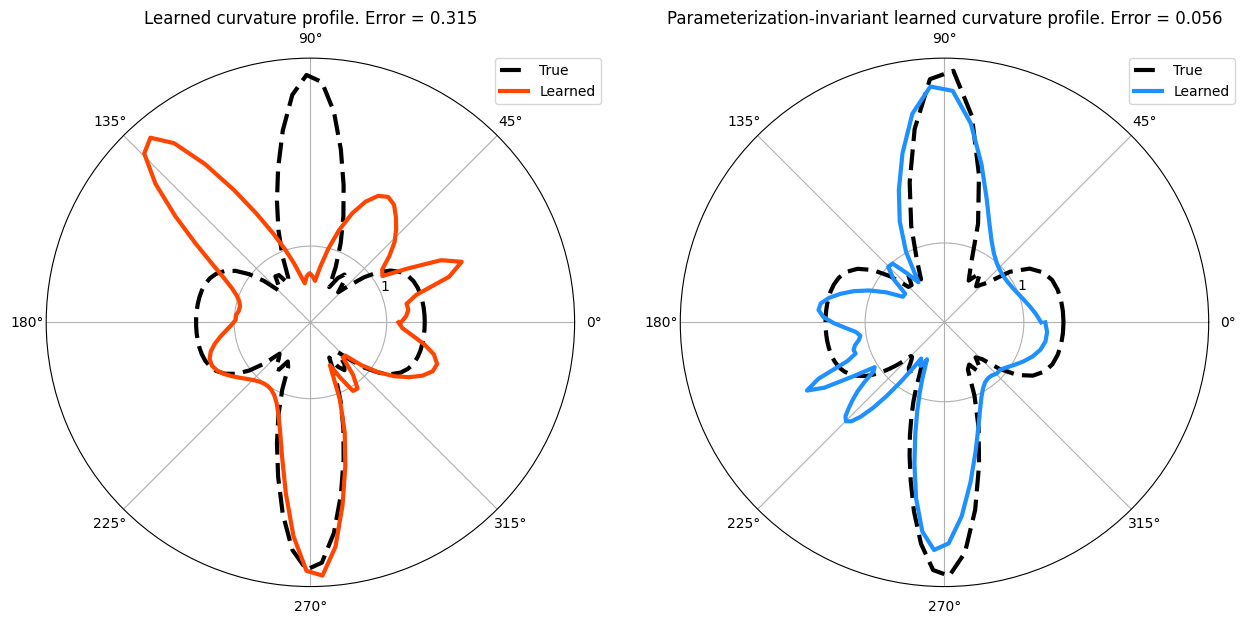

In [49]:
error_no_geodesic = evaluate._compute_curvature_error_s1(
    z_grid_true, curv_norms_learned, curv_norms_true
)
error_geodesic = evaluate._compute_curvature_error_s1(
    rescaled_cumul_geodesic_dists_learned,
    aligned_curv_norms_learned,
    curv_norms_true_interp,
)


fig_polar = plt.figure(figsize=(15, 15))
ax_polar_no_geodesic = fig_polar.add_subplot(121, projection="polar")
ax_polar_no_geodesic.plot(
    z_grid_true,
    0.5 + curv_norms_true,
    label="True",
    dashes=[5, 2],
    linewidth=3,
    color="black",
)
ax_polar_no_geodesic.plot(
    z_grid_learned,
    0.5 + curv_norms_learned,
    label="Learned",
    linewidth=3,
    color="orangered",
)
ax_polar_no_geodesic.set_title(
    "Learned curvature profile. Error = " + f"{error_no_geodesic:.3f}"
)
ax_polar_no_geodesic.set_rticks([1])
ax_polar_no_geodesic.legend(
    bbox_to_anchor=(1.05, 1), loc="upper right", borderaxespad=0
)


ax_polar_geodesic = fig_polar.add_subplot(122, projection="polar")
ax_polar_geodesic.plot(
    rescaled_cumul_geodesic_dists_learned,
    0.5 + curv_norms_true_interp,
    label="True",
    dashes=[5, 2],
    linewidth=3,
    color="black",
)
ax_polar_geodesic.plot(
    rescaled_cumul_geodesic_dists_learned,
    0.5 + aligned_curv_norms_learned,
    label="Learned",
    linewidth=3,
    color="dodgerblue",
)
ax_polar_geodesic.set_title(
    "Parameterization-invariant learned curvature profile. Error = "
    + f"{error_geodesic:.3f}"
)
ax_polar_geodesic.set_rticks([1])
ax_polar_geodesic.legend(bbox_to_anchor=(1.05, 1), loc="upper right", borderaxespad=0)

plt.savefig(
    os.path.join(
        CURVATURE_SHAPES_DIR, f"param_inv_s1_run_id_{run_id}_profile_polar.png"
    )
)
plt.savefig(
    os.path.join(
        CURVATURE_SHAPES_DIR, f"param_inv_s1_run_id_{run_id}_profile_polar.svg"
    )
)